## add to path 

In [1]:
import sys
from pathlib import Path

# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))


Current Directory: D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\indirect_identification\notebooks
Parent Directory: D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems


# open loop

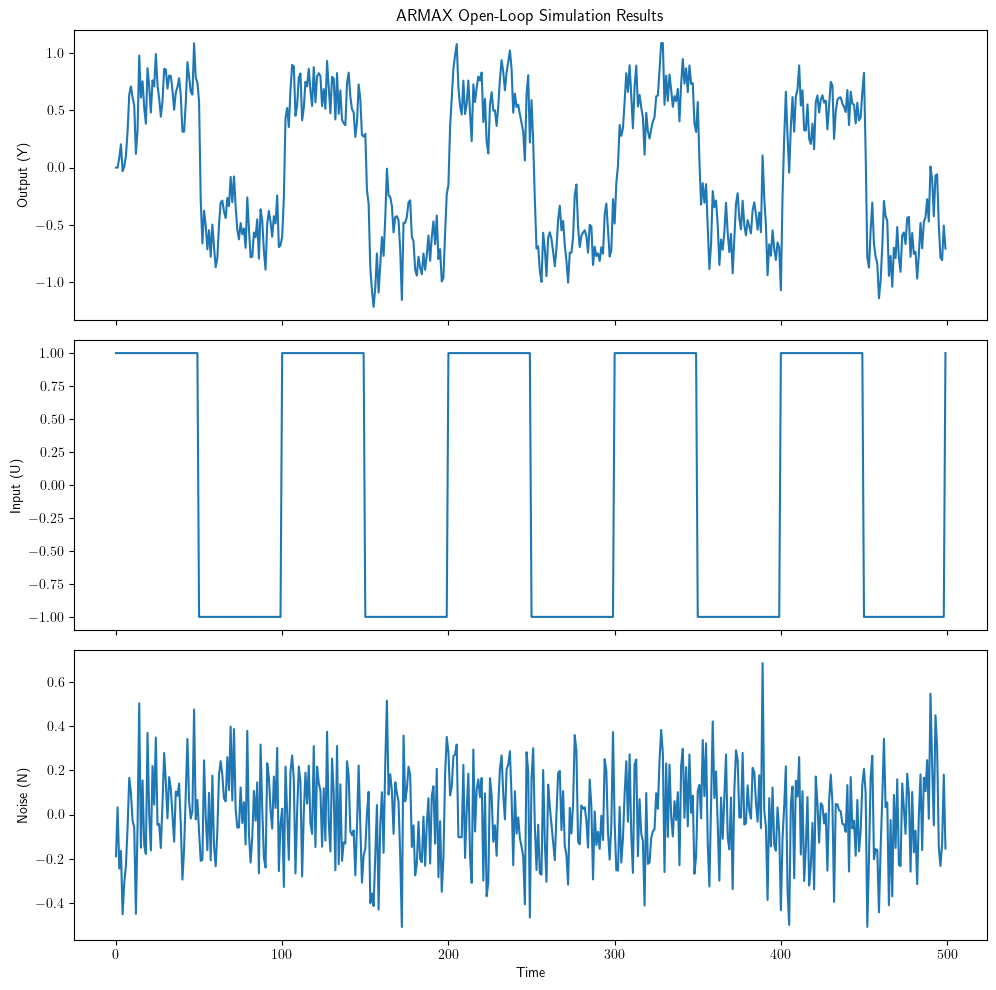

(2, 500) (1, 500)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
# Plotting
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True  # Use full LaTeX engine

class ARMAX:
    def __init__(self, A, B, C):
        self.A = np.array(A)
        self.B = np.array(B)
        self.C = np.array(C)
    
    def simulate_open_loop(self, n_samples, U=None, noise_std=0.1):
        Y = np.zeros((2, n_samples))
        N = np.random.normal(0, noise_std, n_samples)
        
        if U is None:
            U = np.zeros(n_samples)
        
        max_order = max(len(self.A), len(self.B), len(self.C))
        
        for t in range(max_order, n_samples):
            Y[0,t] = (- np.dot(self.A[1:], Y[0,t-1:t-len(self.A):-1]) 
                    + np.dot(self.B, U[t-1:t-len(self.B)-1:-1])
                    + np.dot(self.C, N[t:t-len(self.C):-1]))
            if t>max_order:
                Y[1,t] = Y[0,t] - Y[0,t-1]

        
        return Y, U, N

    def plot_results(self, Y, U, N, R=None):
        fig, axs = plt.subplots(4 if R is not None else 3, 1, figsize=(10, 10), sharex=True)
        
        axs[0].plot(Y[0])
        axs[0].set_ylabel('Output (Y)')
        axs[0].set_title('ARMAX Open-Loop Simulation Results')
        
        axs[1].plot(U)
        axs[1].set_ylabel('Input (U)')
        
        axs[2].plot(N)
        axs[2].set_ylabel('Noise (N)')
        
        if R is not None:
            axs[3].plot(R)
            axs[3].set_ylabel('Reference (R)')
            axs[3].set_xlabel('Time')
        else:
            axs[2].set_xlabel('Time')
        
        plt.tight_layout()
        plt.show()

# Example usage
A = [1, -0.44]   # A(z^-1) = 1 - 0.33z^-1 - 0.1z^-2
B = [0.33]       # B(z^-1) = 0.22z^-1 + 0.1z^-2
C = [1]               # 

armax_model = ARMAX(A, B, C)

n_samples = 500
U = 1* signal.square(np.linspace(0, 10*np.pi, n_samples))

Y, U, noise = armax_model.simulate_open_loop(n_samples, U, noise_std=0.2)
armax_model.plot_results(Y, U, noise)  # No R needed for open-loop
U = U.reshape(1, -1)
print(Y.shape, U.shape)


Error in SPS check: SPS assumption failed: tf(0) = 0.0 != 1.0 (tol=1e-10)
False
Error in SPS check: SPS assumption failed: tf(0) = 0.0 != 1.0 (tol=1e-10)
Error in SPS check: SPS assumption failed: tf(0) = 0.0 != 1.0 (tol=1e-10)
Error in SPS check: SPS assumption failed: tf(0) = 0.0 != 1.0 (tol=1e-10)
Error in SPS check: SPS assumption failed: tf(0) = 0.0 != 1.0 (tol=1e-10)
Error in SPS check: SPS assumption failed: tf(0) = 0.0 != 1.0 (tol=1e-10)
Error in SPS check: SPS assumption failed: tf(0) = 0.0 != 1.0 (tol=1e-10)
Error in SPS check: SPS assumption failed: tf(0) = 0.0 != 1.0 (tol=1e-10)
Error in SPS check: SPS assumption failed: tf(0) = 0.0 != 1.0 (tol=1e-10)
Error in SPS check: SPS assumption failed: tf(0) = 0.0 != 1.0 (tol=1e-10)
Error in SPS check: SPS assumption failed: tf(0) = 0.0 != 1.0 (tol=1e-10)
Error in SPS check: SPS assumption failed: tf(0) = 0.0 != 1.0 (tol=1e-10)
Error in SPS check: SPS assumption failed: tf(0) = 0.0 != 1.0 (tol=1e-10)
Error in SPS check: SPS assumpti

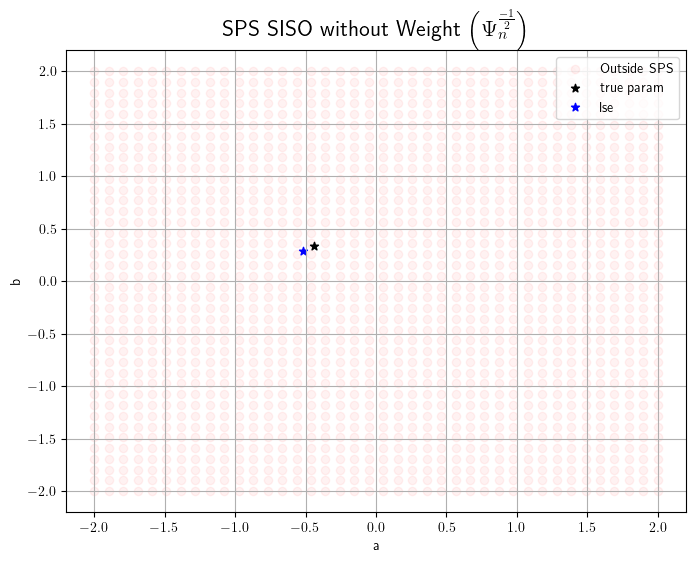

In [9]:
from indirect_identification.sps_indirect import SPS_indirect_model
from numba import njit
from indirect_identification.d_tfs import d_tfs, apply_tf_matrix
from indirect_identification.tf_methods.fast_tfs_methods_fast_math import _is_stable
from dB.sim_db import SPSType
from scipy import optimize

def get_construct_ss_from_params_method(n_states: int, n_inputs: int, n_outputs: int, C: np.array):
    """
    Returns the function to construct state space matrices from parameters.
    """

    def _construct_ss_from_params(params: np.array):
        """
        Returns state space matrices A_obs,B_obs,C_obs,D_obs and the A,B polynomials
        """
        # A: n_state x n_state matrix
        A =  params[:n_states]
        A_obs = np.hstack([np.vstack([np.zeros(n_states-1), np.eye(n_states-1)]), -np.flipud(A.reshape(A.size,-1))])
        # B: n_state x n_input matrix
        B = params[n_states:n_states+n_states*n_inputs].reshape(n_inputs,n_states)
        B_obs = np.flipud(B.T)
        # C: n_output x n_state matrix
        C_obs = C
        # D: n_output x n_input matrix: zero matrix for now
        D_obs = np.zeros((n_outputs,n_inputs))

        A = np.hstack([1, A])
        B = np.hstack([np.zeros((n_inputs,1)), B])

        return A_obs, B_obs, C_obs, D_obs, A, B
    return _construct_ss_from_params

# Example usage
n_dims=1
center = [-0.44, 0.33]
C_obs = np.array([[1]])
epsilon = 1e-10
# sps 
m = 100
q = 5
N = 200

n_output=1
n_states=1
n_inputs=1

def get_error_norm(point, Y, U):
    A = np.array(point[:1])
    A = np.hstack([1, A])
    B = np.array(point[1:])
    B = np.hstack([0, B])
    G = d_tfs((B, A))
    if not _is_stable(A, epsilon=epsilon):
        return 1e10
    try:
        d_tfs.sps_assumption_check(G,0, epsilon)
    except:
        return 1e10

    C = np.array([1])
    Hinv = d_tfs((A, C))

    YGU = Y - G*U
    N = Hinv*YGU
    Lambda = np.array([[1.0, 0],[0, 1.0]]) # shape n_output x n_output
    error_norm = np.linalg.norm(Lambda@N@N.T)
    return error_norm
def get_lse(Y,U):
    x0 = np.zeros(4)
    res = optimize.least_squares(get_error_norm, x0, args=(Y,U))
    params_ls = res.x
    return params_ls

lse = get_lse(Y,U)

model2  = SPS_indirect_model(m=m, q=q, N=N, 
                            n_states=2, n_inputs=1, n_outputs=1, 
                            n_noise=-1)
Y0 = Y[0,:].reshape(1, -1)
def is_inside_region2(point):
    try :
        A = np.array(point[:1])
        A = np.hstack([1, A])
        B = np.array(point[1:])
        B = np.hstack([0, B])
        G = d_tfs((B, A))
        if not _is_stable(A, epsilon=epsilon):
            return False
        
        d_tfs.sps_assumption_check(G,0, epsilon)

        C = np.array([1.0])
        H = d_tfs((C, A))

        d_tfs.sps_assumption_check(H,1.0, epsilon)

        in_sps = model2.sps_indicator(G=G, H=H, A=A, B=B, C=C,
                            Y_t = Y0, U_t=U.reshape(1,-1), sps_type=SPSType.OPEN_LOOP)
    except Exception as e:
        print(f"Error in SPS check: {e}")
        in_sps = False
    return in_sps

print(is_inside_region2(np.array(center)))


# Grid resolution
a_vals = np.linspace(-2, 2, 40)
b_vals = np.linspace(-2, 2, 40)

blue_pts = []
red_pts = []

for a in a_vals:
    for b in b_vals:
        
        point = np.array([a, b])
        if is_inside_region2(point):
            blue_pts.append([a, b])
        else:
            red_pts.append([a, b])

blue_pts = np.array(blue_pts)
red_pts = np.array(red_pts)

# Plotting
plt.figure(figsize=(8, 6))
if len(blue_pts):
    plt.scatter(blue_pts[:, 0], blue_pts[:, 1], color='blue', label='Inside SPS', alpha=0.1)
if len(red_pts):
    plt.scatter(red_pts[:, 0], red_pts[:, 1], color='red', label='Outside SPS', alpha=0.05)
plt.scatter(center[0], center[1], color='black', marker='*', label='true param')
plt.scatter(lse[0], lse[1], color='blue', marker='*', label='lse')
plt.xlabel("a")
plt.ylabel("b")
# plt.title("SPS SISO", fontsize=16)
plt.title(r"SPS SISO without Weight $\left(\Psi_n^{\frac{-1}{2}}\right)$", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [21]:
def _eval_tf(num: np.ndarray, den: np.ndarray, z_inv: float) -> float:
    """
    Efficiently evaluate H(z^{-1}) = num(z^{-1}) / den(z^{-1}) for real z^{-1}
    """
    num_val = 0.0
    den_val = 0.0

    # Numerator: starts at z^{-1}
    z_pow = 1.0
    for i in range(len(num)):
        num_val += num[i] * z_pow
        z_pow *= z_inv

    # Denominator: starts at z^0
    z_pow = 1.0
    for j in range(len(den)):
        den_val += den[j] * z_pow
        z_pow *= z_inv

    return num_val / den_val

_eval_tf(np.array([1.0, -0.33]), np.array([1.0]), z_inv=1)

# H = d_tfs(([1, -0.33],[1.0]))
# H(0)

0.6699999999999999